**Under construction**

Alexander S. Lundervold, November 13th, 2018.

# Introduction

***To be added*** (see also slides)

# Setup

In [1]:
# To ignore some annoying but inconsequential error messages:
import warnings
warnings.simplefilter(action='ignore', category=ConnectionResetError)

In [2]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

import seaborn as sns # For nicer plots

In [4]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

In addition to our standard framework imported above, we'll need both torch and torchvision:

In [5]:
import torch
import torchvision

import torch.nn.functional as F

# Data

We'll use a famous benchmark data set from the computer vision community: <a href="https://www.cs.toronto.edu/~kriz/cifar.html">Cifar-10</a>. 

It consists of 60.000 32x32 color images from 10 different classes:

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

There are 50.000 training images and 10.000 test images. 

<img src="assets/cifar10.png">

## Loading the data into PyTorch

PyTorch (and other deep learning frameworks) operate on what's called **tensors**, which are essentially multidimensional arrays that can be placed on GPUs for accellerated computing. 

To process the Cifar-10 images we need to convert them to tensors:

`utils.py` contains the code used to download the images, normalize them (to improve neural network performance), convert them into tensors, and create data loaders for PyTorch. Take a look if you're curious. 

In [7]:
from utils import get_cifar10, plot_cifar10

Files already downloaded and verified
Files already downloaded and verified


In [8]:
trainloader, testloader = get_cifar10(batch_size=4)

Files already downloaded and verified
Files already downloaded and verified


We can have a look at some images and labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


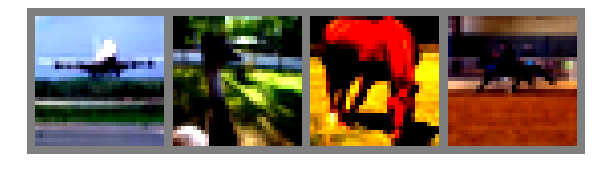

['plane', 'bird', 'horse', 'horse']


In [9]:
plot_cifar10()

# A simple neural network (in PyTorch)

As we discussed in the lecture, there are two stages to training a neural network: a forward pass to get values for all the .., and a backward pass where backpropagation and gradient descent is used to tweak all the weights in the network. 

To make gradient descent work, we need to be able to take the derivative of each component in the network (these derivatives are computed during backpropagation). 

Luckily PyTorch can take care of the differentiation for us (that is, the backward pass) for us if we create a network inheriting from `nn.Module`:

Here's a simple one hidden layer neural network in PyTorch:

In [10]:
input_size = 32*32*3 # The images are 32x32 with three color channels
hidden_size = 84 # We can choose this number

In [11]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        
        super(Net, self).__init__()
        
        # A hidden layer
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        
        # An output layer
        self.fc2 = torch.nn.Linear(hidden_size, num_classes)
        
    # We need to define what we want to happen in the forward phase (the backward phase is automatic)
    
    def forward(self, x):
        
        # Make the 32x32x3 image into a 32*32*3 = 3072 vector
        x = x.view(x.size(0), -1) 
        
        # Feed the input vector through the hidden layer and an activation function
        x = torch.tanh(self.fc1(x)) 
        
        # Output num_classes of numbers.
        # We'll train the network to output a high number for the correct class
        x = self.fc2(x) 
        
        return x

In [12]:
net = Net(input_size = input_size, hidden_size = hidden_size, num_classes = num_classes)

In [13]:
net

Net(
  (fc1): Linear(in_features=3072, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

## Training the network

Remember the steps:
1. Define a neural network (DONE)
2. Collect a batch of training data (we'll use our trainloader)
3. Send these through the network to get its predictions
4. Measure the discrepancy between the true labels and the predictions using a loss function
5. Update all the weights using backpropagation (to calculate the gradients) and gradient descent (to update the weights)

### Training the network on a single batch

In [14]:
# Get the next batch
i, data = next(enumerate(trainloader, 0))

We've now collected the first batch of 4 images:

In [15]:
i

0

In [16]:
images, labels = data

In [17]:
len(images), len(labels)

(4, 4)

The labels of the first four are:

In [18]:
labels

tensor([3, 1, 2, 7])

...which means that the images are of

In [19]:
[classes[label] for label in labels]

['cat', 'car', 'bird', 'horse']

The images are torch tensors:

In [20]:
images.shape

torch.Size([4, 3, 32, 32])

Four images (batch size), 3 color channels, images of size 32x32. 

#### Feeding the batch to the network

In [21]:
outputs = net(torch.autograd.Variable(images))

In [22]:
outputs.shape

torch.Size([4, 10])

As expected, we got four vectors of length 10. Our goal is to make the element in each vector that corresponds to the correct label for the images in the batch as large as possible, while the rest are small. 

Since we haven't trained our network at all yet, we can't expect it to produce any good predictions:

In [23]:
_, predicted = torch.max(outputs.data, 1)

In [24]:
predicted

tensor([4, 2, 4, 4])

In [25]:
labels

tensor([3, 1, 2, 7])

Chances are none of the predictions are correct. Since we've initialized with completely random weights. 

#### Loss function

We'll use our good friend, cross entropy loss (look back to Part 2 to remind yourself about cross entropy):

In [26]:
criterion = torch.nn.CrossEntropyLoss()

Let's calculate the loss for our current batch: 

In [27]:
loss = criterion(outputs, labels)

In [28]:
loss

tensor(2.2289, grad_fn=<NllLossBackward>)

#### Backpropagation

Using the `backward` method PyTorch can calculate how much each weight in the network contributed to the loss by calculating the gradient of the loss with respect to each of them (using a technique called automatic differentation, which is related to the chain rule you know from MAT108):

In [29]:
loss.backward()

#### Gradient descent

Now we can update all the weights using stochastic gradient descent:

In [30]:
learning_rate = 0.01

In [31]:
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

Take one step with the optimizer to modify each weight:

In [32]:
optimizer.step()

The network has now been trained *a tiny bit* (it has learned from the first four images). 

Let's see if that helped:

In [33]:
outputs = net(torch.autograd.Variable(images))

In [34]:
_, predicted = torch.max(outputs.data, 1)

In [35]:
predicted

tensor([3, 1, 2, 7])

In [36]:
labels

tensor([3, 1, 2, 7])

The network improved (on these four images on which it trained..)

### Going through the training data, batch by batch

The idea now is to repeat this batch by batch, until we've been thriugh the entire training data set multiple times. The idea is that gradient descent will then be able to find good settings for all the weights, which we then can use when new data arrives. 

Let's first create a simple function for checking the accuracy of the network on the test data:

In [37]:
def check_accuracy(net):
        correct = 0
        total = 0
        
        # Feed all the test data through the net and count the number of correct predictions:
        for data in testloader:
            images, labels = data
            outputs = net(torch.autograd.Variable(images))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        
        accuracy = correct.numpy() / total
            
        print('The accuracy of the network on the 10.000 test images is: %d %%' % (100 * accuracy))
        
        return accuracy

Our current accuracy after training on a single batch is

In [38]:
_ = check_accuracy(net)

The accuracy of the network on the 10.000 test images is: 12 %


Since the network is essentially untrained this is as expected (randomly guessing among the 10 classes gives an accuracy of 10%).

Here's the entire procedure for feeding batches through the network. You can CTRL+ENTER this cell to run it multiple times. You'll see the accuracy improve.

In [39]:
learning_rate = 0.001

In [40]:
# Get next batch
i, data = next(enumerate(trainloader, 0))
images, labels = data
# A technicality: we have to zero out the gradients each time, 
# otherwise they'll accumulate
optimizer.zero_grad()
# Collect the outputs
outputs = net(images)
# Compute the loss
loss = criterion(outputs, labels)
print(f'Current loss: {loss}')
# Compute the gradients of the loss with respect to all the weights
loss.backward()
# Update the weights using gradient descent
optimizer.step()
# Compute the current accuracy
_ = check_accuracy(net)

Current loss: 2.530843734741211
The accuracy of the network on the 10.000 test images is: 14 %


> How many times do you have to run the above cell to go through the entire training data set once? 

Let's make a loop!

We'll go through the entire training set 2 times:

In [41]:
num_epochs = 2

In [42]:
accuracies = []
for epoch in range(num_epochs): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data
        if i % 1000 == 999:    # print every 1000nd batch         
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            
            acc = check_accuracy(net)
            accuracies.append(acc)
            running_loss = 0.0

print('Training complete')

[1,  1000] loss: 1.998
The accuracy of the network on the 10.000 test images is: 33 %
[1,  2000] loss: 1.855
The accuracy of the network on the 10.000 test images is: 36 %
[1,  3000] loss: 1.820
The accuracy of the network on the 10.000 test images is: 36 %
[1,  4000] loss: 1.808
The accuracy of the network on the 10.000 test images is: 37 %
[1,  5000] loss: 1.811
The accuracy of the network on the 10.000 test images is: 37 %
[1,  6000] loss: 1.784
The accuracy of the network on the 10.000 test images is: 38 %
[1,  7000] loss: 1.800
The accuracy of the network on the 10.000 test images is: 37 %
[1,  8000] loss: 1.783
The accuracy of the network on the 10.000 test images is: 37 %
[1,  9000] loss: 1.789
The accuracy of the network on the 10.000 test images is: 37 %
[1, 10000] loss: 1.751
The accuracy of the network on the 10.000 test images is: 38 %
[1, 11000] loss: 1.759
The accuracy of the network on the 10.000 test images is: 38 %
[1, 12000] loss: 1.761
The accuracy of the network on 

We can plot the accuracy changes during training:

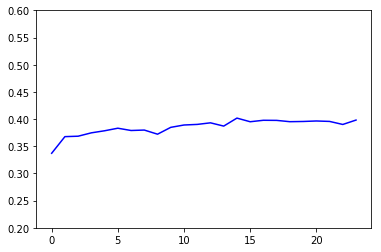

In [43]:
plt.ylim([0.2, 0.6])
plt.plot(accuracies, 'b')
plt.show()

We see that we quickly reach what seems to be a plateau in accuracy. We need something else to go beyond 40%...

> **That's it**, basically! Now you know some of the basics of training a neural network!

However, our above neural network is not particularly powerful. We can do much, much better...

# Deep learning

***To be added***

> **Your turn!** Train a convolutional neural network to recognize the handwritten digits in the MNIST data set. Compare your result with what we got using logistic regression back in Part 2.